# Symbolic, Numerical, and Automatic Differentiation

Machine Learning Fundamentals for Economists

Jesse Perla (University of British Columbia)

# Overview

## Why the Emphasis on Differentiation?

-   Modern ML would be impossible without (1) software that makes
    calculating gradients easy; and (2) specialized hardware
-   Old methods, but flexible software + hardware have radically changed
    the scale of problems we can solve
-   You simply can’t solve large problems (or sample from
    high-dimensional distributions) without gradients, or jacobian of
    constraints
-   A mental shift was towards “differentiable programming”, i.e. to
    treat entire software programs as differentiable, nested functions
    -   As long as you have helpful software to manage the bookkeeping
    -   You can **differentiate almost anything** continuous, and at
        least expectations or distributions of almost anything discrete

## Types of Differentiation

A few general types of differentiation

1.  Numerical Differentiation (i.e., finite differences)

2.  Symbolic Differentiation (i.e., chain rule and simplify
    subexpressions by hand)

3.  Automatic Differentiation (i.e., execute chain rule on computer)

    -   Use the chain rule forwards vs. backwards
    -   Think matrix-free methods

4.  Sparse Differentiation (i.e., use one of the above to calculate
    directional derivatives, potentially filling in sparse Jacobians
    with fewer passes)

# Numerical Derivatives

## Finite Differences

-   With $f : \mathbb{R}^N \to \mathbb{R}^M$, take $e_i$ as the $i$th
    standard basis vector

$$
\frac{\partial f(x)}{\partial x_i} \approx \frac{f(x + \epsilon e_i) - f(x)}{\epsilon}
$$

-   Requires $N$ forward passes for the full $\nabla f(x)$. Same as
    forward-mode AD.
-   Good rule of thumb with above is
    $\epsilon = \sqrt{\epsilon_{\text{machine}}}$
-   Tough tradeoffs: roundoff vs. truncation errors
    -   $\epsilon$ too small hit machine precision errors, especially
        with GPUs
    -   $\epsilon$ too large and the approximation is bad
-   Still useful in many cases, especially for sparse problems

## More Points for More Accuracy

-   Trickier in practice to handle tradeoff than you might expect
-   Could use more points which improves accuracy at the cost of more
    function evaluations. e.g. 5 point central differences

$$
f'(x) \approx \frac{-f(x-2\epsilon) + 8f(x-\epsilon) - 8f(x+\epsilon) + f(x+2\epsilon)}{12\epsilon}
$$

-   In that case, use $\epsilon = \sqrt[4]{\epsilon_{\text{machine}}}$

# Symbolic Differentiation

## Roll up Your Sleeves

-   Do it by hand, or use Mathematica/Sympy/etc
-   Seems like it should always be better?
    -   Often identical to auto-differentiation, though it gives you
        more control over algebra with subexpressions. Prone to algebra
        or coding errors
    -   Substituting expressions could speed things up (or slow things
        down)
    -   Less overhead than many auto-differentiation methods, which may
        lead to better performance. Or may not if you do a different
        calculation (e.g. flatten the computational graph)
-   Very useful in many cases, even if only for designing new AD
    “primitives”

## Sub-Expressions and Computational Graphs

-   Take $f(g(x), h(g(x)))$. Would you want to substitute/simplify the
    gradient?

$$
f'(x) = g'(x) f_1(g(x), h(g(x))) + g'(x) h'(g(x)) f_2(g(x), h(g(x)))
$$

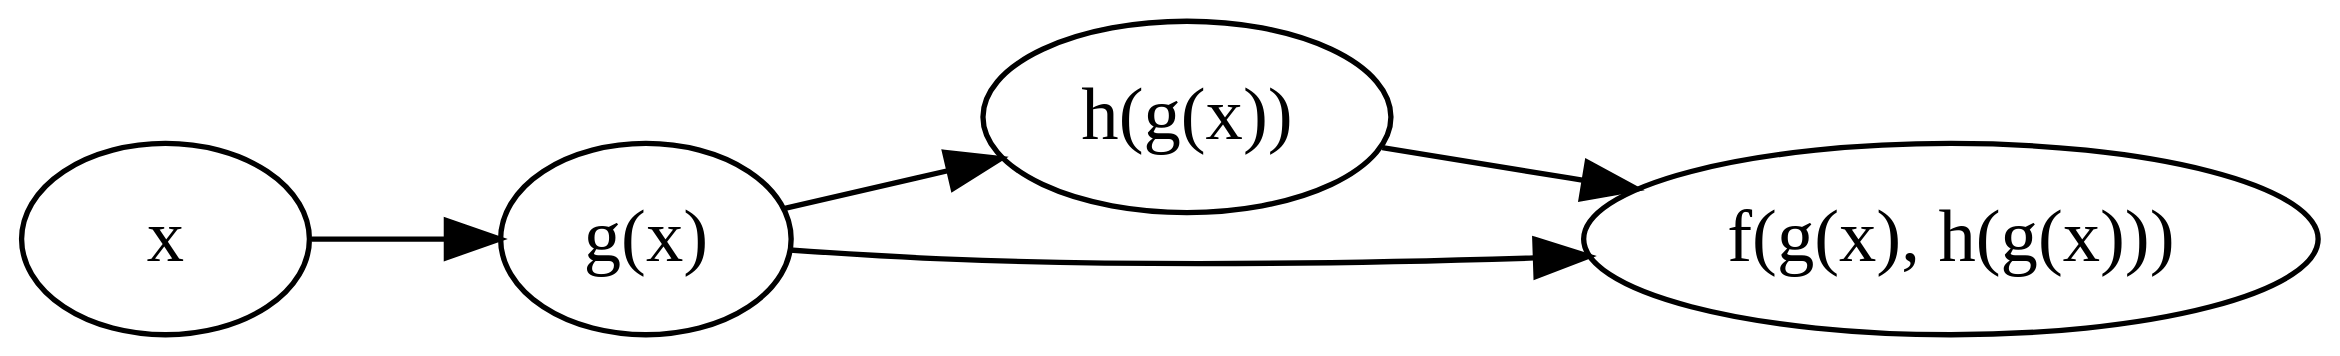

# Automatic Differentiation

## Let the Computer Execute the Chain Rule

-   Auto-differentiation/differentiable programming works on “computer
    programs”. i.e., computational graphs are just functions

    1.  Converts the program into a computational graph (i.e., nested
        functions)
    2.  Apply the chain rule to the computational graph recursively
    3.  Provide library of “primitives” where the recursion stops, and
        provides registration of new primitives to teach the computer
        calculus

Finally: many frameworks will compile the resulting sequence of
operations to be efficient on a GPU since this is so central to deep
learning performance

## Forward and Reverse Mode

-   The chain rule can be done forwards or backwards
-   See
    [Wikipedia](https://en.wikipedia.org/wiki/Automatic_differentiation#Forward_and_reverse_accumulation)
    for good examples. Intuition for
    $f : \mathbb{R}^N \to \mathbb{R}^M$:
    -   Forward-Mode: grab one of the $N$ inputs and **wiggle** it to
        see impact on all $M$ outputs. Need $N$ passes to get full
        Jacobian
    -   Reverse-Mode: grab one of the $M$ outputs and **wobble** it to
        see impact on all $N$ inputs. Need $M$ passes to get full
        Jacobian
-   Hence, reverse-mode is good for calculating gradients when $N \gg M$
    (e.g. neural networks). If $M = 1$ gradients are the same complexity
    as evaluating the function
-   Reverse-mode has significant overhead, so often forward-mode is
    preferred even if $N > M$

## Forward and Backwards With the Computational Graph

-   See
    [wikipedia](https://en.wikipedia.org/wiki/Automatic_differentiation#Forward_and_reverse_accumulation)
    for classic treatment, and [ProbML:
    Introduction](https://probml.github.io/pml-book/book1.html) Section
    13.3 for a special case
-   Useful to read, but missing key linear algebra interpretations that
    are useful for understanding how to adapt AD
-   Instead, we will think of AD as linearization/etc. and follow
    [ProbML: Advanced
    Topics](https://probml.github.io/pml-book/book2.html) and the JAX
    documentation
    -   While we won’t cover it, this is much more amenable to
        higher-order derivatives and perturbations

## Reminder: Filling in a Matrix from a Linear Operator

-   A standard basis in $\mathbb{R}^2$ is
    $e_1 = \begin{bmatrix} 1 & 0 \end{bmatrix}^{\top}$ and
    $e_2 = \begin{bmatrix} 0 & 1 \end{bmatrix}^{\top}$
-   Given linear operator $\mathcal{A} : \mathbb{R}^2 \to \mathbb{R}^3$
    and adjoint $\mathcal{A}^{\top} : \mathbb{R}^3 \to \mathbb{R}^2$ how
    can we get the underlying matrix (i.e. $A$ such that
    $\mathcal{A}(v) = A v$ for all $v\in\mathbb{R}^2$)?

1.  Use the standard basis vectors $e_1, e_2$ and calculate
    $\mathcal{A}(e_1), \mathcal{A}(e_2)$

    -   Gives two columns of the $A$ matrix, so
        $A = \begin{bmatrix} \mathcal{A}(e_1) & \mathcal{A}(e_2) \end{bmatrix}$

2.  Use the standard basis vectors $e_1, e_2, e_3$ (now of
    $\mathbb{R}^3$) and calculate
    $\mathcal{A}^{\top}(e_1), \mathcal{A}^{\top}(e_2), \mathcal{A}^{\top}(e_3)$

    -   Gives the three columns of $A^{\top}$,
        i.e. $A^{\top} = \begin{bmatrix} \mathcal{A}^{\top}(e_1) & \mathcal{A}^{\top}(e_2) & \mathcal{A}^{\top}(e_3) \end{bmatrix}$

## Jacobians and Linearization

-   Differentiation linearizes around a point, yielding the Jacobian
-   i.e., for $f : \mathbb{R}^N \to \mathbb{R}^M$, then
    $x \to \partial f(x)$ maps to an $N \times M$ Jacobian matrix
    -   But remember matrix-free linear operators!
-   Instead of the Jacobian as a matrix, think of matrix-vector products
    and $\partial f(x) : \mathbb{R}^N \to \mathbb{R}^M$ as a linear
    operator
    -   Note: $x$ is the linearization point in that notation, not the
        argument
-   See [ProbML: Advanced
    Topics](https://probml.github.io/pml-book/book2.html) Chapter 6

## Push-Forwards and JVPs

-   Denote the operator, linearized around $x$, and applied to
    $v\in\mathbb{N}$ as

    $$
    (x, v) \mapsto \partial f(x)[v] \in \mathbb{R}^M
    $$

    -   This is called the “push-forward”. The Jacobian Vector Product
        (JVP)
    -   i.e. $\nabla f(x) \cdot v$, as the product of the jacobian and a
        direction

-   JAX (and others) will take an $f$ and an $x$ and compile a new
    function from $\mathbb{R}^N$ to $\mathbb{R}^M$ that calculates
    $\partial f(x)[v]$

## Adjoints, Pullbacks, and VJPs

-   Just as we can transpose a linear operator, we can transpose the
    Jacobian around the linearization point, $x$

$$
\partial f(x)^{\top} : \mathbb{R}^M \to \mathbb{R}^N
$$

-   Which lets us define the “pullback”:
    $(x, u) \mapsto \partial f(x)^{\top}[u] \in \mathbb{R}^N$
-   Just as with matrix-free linear operators, we can think of this as
    an inner product: The Vector Jacobian Product (VJP)
-   i.e., $u \cdot \nabla f(x)$ or $\nabla f(x)^{\top} \cdot u$ is the
    reason for the “adjoint” terminology
-   JAX (and others) will take an $f$ and an $x$ and compile a new
    function from $\mathbb{R}^M$ to $\mathbb{R}^N$ that calculates
    $\partial f(x)^{\top}[u]$

## Example of a Jacobian

Let $f : \mathbb{R}^2 \to \mathbb{R}^2$ be defined as

$$
f(x) \equiv \begin{bmatrix}
x_1^2 + x_2^2 \\
x_1 x_2
\end{bmatrix}
$$

Then

$$
\nabla f(x) \equiv \begin{bmatrix}
2 x_1 & 2 x_2 \\
x_2 & x_1
\end{bmatrix}
$$

## JVP

Let $v = \begin{bmatrix} 1 & 0 \end{bmatrix}^{\top}$, i.e. the $e_1$ in
the standard basis then

$$
\partial f(x)[v] = \nabla f(x) \cdot \begin{bmatrix} 1 \\ 0 \end{bmatrix} = \begin{bmatrix}
2 x_1 \\ x_2 \end{bmatrix}
$$

-   Each gives a column of the Jacobian
-   Could use $e_1, \ldots, e_N$ to get the full Jacobian

## VJP

-   Let $u = \begin{bmatrix} 1 & 0 \end{bmatrix}^{\top}$, i.e. the $e_1$
    in the standard basis then

$$
\partial f(x)^{\top}[u] = \begin{bmatrix} 1 & 0 \end{bmatrix} \cdot \nabla f(x) = \begin{bmatrix} 2 x_1 & 2 x_2 \end{bmatrix}
$$

-   The first row of the Jacobian (or the first column of its transpose)
-   Could use $e_1,\ldots,e_M$ we can get the full Jacobian

## Chain Rule for JVP

-   Consider $f : \mathbb{R}^N \rightarrow \mathbb{R}^M$ with
    $f = c \circ b \circ a$

$$
\partial f(x) = \partial c(b(a(x))) \circ \partial b(a(x)) \circ \partial a(x)
$$

-   JVP against an input perturbation $v \in \mathbb{R}^N$
-   Moving inside out because as we perturbing inputs

$$
\partial f(x)[v] = \partial c(b(a(x))) \left[ \partial b(a(x))[\partial a(x)[v]] \right]
$$

## Calculation Order for JVP Chain Rule

$$
\partial f(x)[v] = \partial c(b(a(x))) \left[ \partial b(a(x))[\partial a(x)[v]] \right]
$$

-   Calculation order inside out, recursively finding linearization
    points:

    1.  $\partial a(x)[v]$ and $a(x)$
    2.  $\partial b(a(x))[\partial a(x)[v]]$ and $b(a(x))$
    3.  $\partial c(b(a(x)))[\partial b(a(x))[\partial a(x)[v]]]$ (and
        $c(b(a(x)))$ if required)

-   Conveniently follows calculating “primal” calculation. Many ways to
    do it (e.g. overloading, duals)

-   Can calculate the “primal” and the “push-forward” at the same time

## Chain Rule for VJP

$$
\partial f(x) = \partial c(b(a(x))) \circ \partial b(a(x)) \circ \partial a(x)
$$

-   Take the transpose,

$$
\partial f(x)^{\top} = \partial a(x)^{\top} \circ \partial b(a(x))^{\top} \circ \partial c(b(a(x)))^{\top}
$$

-   In particular, if we multiply by some $u \in \mathbb{R}^M$ (i.e.,
    $u \cdot \nabla f(x)$), we get

$$
\partial f(x)^{\top}[u] = \partial a(x)^{\top} \left[ \partial b(a(x))^{\top} \left[ \partial c(b(a(x)))^{\top}[u] \right] \right]
$$

## Calculation Order for VJP Chain Rule

$$
\partial f(x)^{\top}[u] = \partial a(x)^{\top} \left[ \partial b(a(x))^{\top} \left[ \partial c(b(a(x)))^{\top}[u] \right] \right]
$$

-   Calculation order outside in (of original):
    1.  $a(x), b(a(x)), c(b(a(x)))$ (i.e., the “primal” calculations
        required for linearization points)
    2.  $\partial c(b(a(x)))^{\top}[u]$
    3.  $\partial b(a(x))^{\top}[\partial c(b(a(x)))^{\top}[u]]$
    4.  $\partial a(x)^{\top}[\partial b(a(x))^{\top}[\partial c(b(a(x)))^{\top}[u]]]$
-   Unlike with JVP, we need the full calculations before going
    backwards through the computational graph at the end (i.e.,
    “backprop” terminology)

## Complexity with Reverse-Mode AD

-   In principle for $f : \mathbb{R}^N \to \mathbb{R}$ can calculate
    $\nabla f(x)$ in the same computational order as $f$ itself -
    independent of $N$
    -   This is a key part of the secret sauce that makes ML possible
-   But in practice it isn’t quite so simple
    -   Requires storage for entire “primal” graph before going
        backwards (unlike forward-mode). Inplace operations in primal
        often useless
    -   Requires more complicated code to keep track of the steps in the
        computational graph, which creates overhead
-   This means that often forward-mode will be faster even when $N > M$
    (e.g., mabye 50-100 dimensions, but depends)

## Sparse Differentiation

-   For the full Jacobian a $f : \mathbb{R}^N \rightarrow \mathbb{R}^M$
    you need either $N$ forward passes or $M$ backwards passes
    -   But if sparse, then maybe could use better directional
        derivatives than $e_i$
    -   e.g. Tridiagonal matrices can be done with 3 directional
        derivatives.
-   See
    [SparseDiffTools.jl](https://github.com/JuliaDiff/SparseDiffTools.jl)
    and use
    [FiniteDiff.jl](https://github.com/JuliaDiff/FiniteDiff.jl#tutorial-2-fast-sparse-jacobians)
    -   See [sparsejac](https://github.com/mfschubert/sparsejac) for an
        experimental version in JAX?
-   Finding the right directional derivatives is hard and requires
    knowing the sparsity pattern (and solves a problem equivalent to
    graph coloring)

# AD Implementation and Examples

## Software and Implementation

-   Tracking the computational graph for reverse-mode is tricky
    (especially if there were inplace modifications)
    -   Mutating support rare for reverse-mode, functional style typical
-   The recursion goes forwards, backwards, or both both ways down the
    computational graph until it hits a primitive
    -   Recursion stops when it hits a function that has JVP/VJP
        implemented
-   These are two extreme cases, where in principle you can mix then
    (e.g., an internal a function has
    $\mathbb{R}^N \to \mathbb{R}^K \to \mathbb{R}$, where $K \gg N$,
    then use forward-mode from $K \to N$ and reverse-mode from
    $N \to 1$)
-   Similar methods apply for higher order derivatives,
    e.g. Hessian-vector products and taylor series

## Pytorch

-   See [Probabilistic ML: Chapter 8
    Notebook](https://github.com/probml/pyprobml/blob/master/notebooks/book1/08/autodiff_pytorch.ipynb)
-   Reverse-mode centric, especially convenient for neural networks but
    can be confusing for general functions
-   In general, you will find it the most convenient for a standard
    supervised learning problems (e.g. neural networks with empirical
    risk minimization)
-   We will discuss later when we look at ML pipelines

In [1]:
import torch

## Example with Pytorch `.backward()`

-   Reverse-mode AD passes values with `requires_grad=True`
-   Traces the intermediates, and does the AD on `.backward()`

In [2]:
x = torch.tensor(2.0, requires_grad=True)
# Trace computations for the "forward" pass
y = torch.tanh(x)
# Do the "backward" pass for Reverse-mode AD
y.backward()
print(x.grad)

def f(x, y):
    return x**3 + 2 * y[0]**2 - 3 * y[1] + 1

x = torch.tensor(1.0, requires_grad=True)
y = torch.tensor([2.0, 3.0],
                  requires_grad=True)
z = f(x, y)
z.backward()
print(x.grad, y.grad)

tensor(0.0707)
tensor(3.) tensor([ 8., -3.])

## JAX

-   Very flexible with high level tools (e.g. `grad` is
    $\mathbb{R}^N \to \mathbb{R}$ reverse-diff) as well as lower-level
    functions to directly use `jvp`, `vjp`, and hessian-vector products
-   Emphasizing JAX here because non-trivial algorithms will typically
    require more flexibility to scale (e.g., cross-derivatives,
    matrix-free, etc.)
-   Easier to use for general functions rather than in standard
    estimation pipelines
-   See [JAX Autodiff
    Cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html)
-   See [Probabilistic ML: Chapter 8
    Notebook](https://github.com/probml/pyprobml/blob/master/notebooks/book1/08/autodiff_jax.ipynb)
-   See [JAX Advanced
    Autodiff](https://jax.readthedocs.io/en/latest/jax-101/04-advanced-autodiff.html)

## JAX Setup

-   From [Autodiff
    cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html)
    and [ProbML book 1 chapter
    8](https://github.com/probml/pyprobml/blob/master/notebooks/book1/08/autodiff_jax.ipynb)
-   Random numbers always require keys, which can be split for
    reproducibility
-   Use `jax.config.update('jax_enable_x64', True)` for 64bit precision
    (default is 32bit)

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import grad, jit, vmap
from jax import random, vjp, jvp
key = random.PRNGKey(0)
subkey1, subkey2 = random.split(key)
random.normal(subkey1, (2,))

Array([ 1.0040143, -0.9063372], dtype=float32)

## High Level Grad (i.e. Reverse-mode)

-   `grad` is the high-level reverse-mode AD function
-   Returns a new function, which could be compiled

In [4]:
grad_tanh = grad(jnp.tanh)
print(grad_tanh(2.0))
grad_tanh_jit = jit(grad_tanh)
print(grad_tanh_jit(2.0))

def f(x):
    return x**3 + 2 * x**2 - 3 * x + 1
print(grad(f)(1.0))
@jit
def f2(x):
    return x**3 + 2 * x**2 - 3 * x + 1
grad(f2)(1.0)

0.070650816
0.070650816
4.0

Array(4., dtype=float32, weak_type=True)

## Fixing an argument

In [5]:
def f3(x, y):
    return x**2 + y
v, gx = jax.value_and_grad(f3, argnums=0)(2.0, 3.0)
print(v)
print(gx)

gy = grad(f3, argnums=1)(2.0, 3.0)
print(gy)

7.0
4.0
1.0

## Full Jacobians (Forward and Reverse)

-   Goes through full basis forwards or backwards

In [6]:
def fun(x):
    return jnp.dot(A, x)
A = np.random.normal(size=(4, 3))
x = np.random.normal(size=(3,))
Jf = jax.jacfwd(fun)(x)
Jr = jax.jacrev(fun)(x)
print(np.allclose(Jf, Jr))

True

## Setup for Logistic Regression

In [7]:
def sigmoid(x):
    return 0.5 * (jnp.tanh(x / 2) + 1)

def predict(W, b, inputs):
    return sigmoid(jnp.dot(inputs, W) + b)
inputs = jnp.array([[0.52, 1.12,  0.77],
                   [0.88, -1.08, 0.15],
                   [0.52, 0.06, -1.30],
                   [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])                   
key, W_key, b_key = random.split(key, 3)
W = random.normal(W_key, (3,))
b = random.normal(b_key, ())                    

## JVP

In [8]:
f = lambda W: predict(W, b, inputs)
key, subkey = random.split(key)
v = random.normal(subkey, W.shape)

# Push forward
y, u = jvp(f, (W,), (v,))
print((y, u))

(Array([0.10947311, 0.79829013, 0.41004258, 0.99217653], dtype=float32), Array([-0.19177328, -0.13542867,  0.18863559, -0.01155983], dtype=float32))

## VJP

In [9]:
y, vjp_fun = vjp(f, W)

key, subkey = random.split(key)
u = random.normal(subkey, y.shape)

# Pull back
# Note need to call function
print((y, vjp_fun(u)))

(Array([0.10947311, 0.79829013, 0.41004258, 0.99217653], dtype=float32), (Array([ 0.24380712, -0.29951894, -0.55004   ], dtype=float32),))

## Differentiating PyTrees

-   Key JAX feature is “flattening” of nested data
-   Works for arbitrarily nested tree structures

In [10]:
def loss2(params_dict):
    preds = predict(params_dict['W'], params_dict['b'], inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.sum(jnp.log(label_probs))
params = {'W': W, 'b': b}
print(grad(loss2)(params))

{'W': Array([-0.433146 , -0.7354605, -1.2598922], dtype=float32), 'b': Array(-0.69001776, dtype=float32)}

# Implicit Differentiation and Custom Rules

## Primal and JVP/VJP Calculations are Separate

-   For a JVP or VJP, we first need to calculate the $f(x)$

    -   This could involve complicated algorithms, external libraries,
        etc.

-   Often madness to descend recursively into primal calculations

    -   e.g. if $f(x) = \cos(x)$ then should it step inside $\cos(x)$?
    -   Alternatively, use the known derivative to find

    $$
    \partial f(x)[v] = -\sin(x) \cdot v
    $$

-   AD systems all have a library of these rules, and typically a way to
    create new ones for “custom” rules for complicated functions

## Custom Rules/Primitives

-   Derive the derivative by hand, and register it with the AD system
-   See [Matrix
    Algebra](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)
    and [Matrix Derivative
    Results](https://people.maths.ox.ac.uk/gilesm/files/AD2008.pdf), and
    [ChainRules.jl
    Docs](https://juliadiff.org/ChainRulesCore.jl/stable/maths/arrays.html)
    for examples
-   Derivations for forward-mode is relatively easier using the total
    derivative
-   Derivations for reverse-mode is difficult.
    -   See tricks for reverse using the trace of the Frobenius Inner
        product.
-   See
    [here](https://jax.readthedocs.io/en/latest/notebooks/Custom_derivative_rules_for_Python_code.html)
    for JAX implementation

## Smooth Matrix Functions

-   Consider $f : \mathbb{R}^{N \times N} \to \mathbb{R}^{N \times N}$
    and following Mathias 1996 and Higham 2008
-   Assume a suitably smooth function and a perturbation $\delta A$,
    where we want to calculate the forward-mode
    $\partial f(A)[\delta A]$
-   Then, apply $f(\cdot)$ to the following $\mathbb{R}^{2N \times 2 N}$
    block matrix and extract the answer form the upper right corner $$
    f\left(\begin{bmatrix} A & \delta A\\ 0 & A\end{bmatrix}\right) = \begin{bmatrix} f(A) & \partial f(A)[\delta A]\\ 0 & f(A)\end{bmatrix}
    $$
    -   This is a remarkable result true for any $\delta A$. Not always
        the most efficient way, but very general

## Registering JVPs in JAX

In [11]:
@jax.custom_jvp
def f(x, y):
  return jnp.sin(x) * y
@f.defjvp
def f_jvp(primals, tangents):
  x, y = primals
  x_dot, y_dot = tangents
  primal_out = f(x, y)
  tangent_out = jnp.cos(x) * x_dot * y + jnp.sin(x) * y_dot
  return primal_out, tangent_out

print(f(2., 3.))
y, y_dot = jvp(f, (2., 3.), (1., 0.)) # perturb x, not y
print(y, y_dot)  

2.7278922
2.7278922 -1.2484405

## Deriving Rules for Matrix Inverse

-   Let $f : \mathbb{R}^{N \times N} \to \mathbb{R}^{N \times N}$ where
    $f(A) = A^{-1} = C$

$$
\begin{aligned}
I &= C A\\
0 &= \partial C A + C \partial A \\
0 &= \partial C A C + C (\partial A) C \\
0 &= \partial C + C (\partial A) C \\
\partial C &= -C (\partial A) C \\
\end{aligned}
$$

-   So given the $A$, the “primal” can be calculated $C = A^{-1}$ using
    the appropriate method (e.g. LU decomposition, cholesky, etc.)
-   Then the forward mode AD is just matrix products
-   Reverse is harder to derive
    ($\partial A = - C^{\top} (\partial C) C^{\top}$)

## Implicit Functions

-   The implicit function theorem helps us linearize around a solution
-   For example:
    -   [Optimistix](https://docs.kidger.site/optimistix/) for root
        finding and optimization in JAX
    -   [DSGE
        solutions](https://github.com/HighDimensionalEconLab/DifferentiableStateSpaceModels.jl)
    -   [Dynamax](https://github.com/probml/dynamax) for Filters and
        State Space Models
    -   See [Implicit Layers
        Tutorial](http://implicit-layers-tutorial.org/implicit_functions/)
        for fixed point example and for [differentiable
        optimizers](http://implicit-layers-tutorial.org/differentiable_optimization/)

## Differentiating a Fixed Point Solution

-   Solve primal problem $z^*(a) = f(a, z^*(a))$ for $z^*(a)$ using
    Anderson iteration, Newton, etc. fixing $a$. Use implicit function
    theorem at $z^* \equiv z^*(a_0)$ $$
    \frac{\partial z^*(a)}{\partial a} = \left[ I - \frac{\partial f(a, z^*)}{\partial z} \right]^{-1} \frac{\partial f(a, z^*)}{\partial a}.
    $$

-   For JVP: $(a, v) \mapsto \frac{\partial z^*(a)}{\partial a}v$

$$
\frac{\partial z^*(a)}{\partial a}\cdot v = \left[ I - \frac{\partial f(a,z^*)}{\partial z} \right]^{-1} \frac{\partial f(a, z^*)}{\partial a}\cdot v
$$

-   Note that this requires the gradients of $f(a, z)$ using symbolics,
    AD, etc.

## JAX Packages with Builtin Implicit Differentiation

-   Most JAX and Pytorch packages will be built with AD rules

In [12]:
import optimistix as optx

def F(x, factor):
    return factor * x ** 3 - x - 2

@jax.jit
def root(factor):
    solver = optx.Newton(rtol=1e-6, atol=1e-6)
    sol = optx.root_find(F, solver, y0=jnp.array(1.5),
                         args=factor, max_steps=20, throw=False)
    return sol.value

# Derivative of root with respect to factor at 2.0
print(grad(root)(2.0))

-0.22139916